# Modeling Transit Time Distributions of Microvascular Networks: Figure Creation

Nathan Karst and John Geddes

In [1]:
import numpy as np
import pandas as pd
import scipy.io

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle

import skeleton
from network import *
from ttd import *

## Manuscript Figures

In [2]:
def load(prefix):
    eqs = scipy.io.loadmat(f'data/{prefix}_eqs.mat')['eqs']
    f = open(f'data/{prefix}_params.p','rb')
    params = pickle.load(f)
    f.close()
    
    out = Network(params)
    out.equilibria = eqs
    
    return out

# This is a parent class that is meant only to be inherited. 
class ManuscriptFigure:
    def __init__(self,network):
        self.network = network
        self._orig_h = network.h.copy()

    def restore_network_state(self):
        self.network.set_state(self._orig_h)
        self.network.compute_ttd()
    
    def check_ttds(self):
        for i in range(self.network.equilibria.shape[1]):
            self.network.state = self.network.equilibria[:,i]
            self.network.hematocrits()
            self.network.compute_ttd()
            print(f'Eq {i}:')
            print(f'\tCum. prob. of TTD:{self.network.ttd.probs.sum()}')
            print(f'\tMax. H in net.:{self.network.h.max()}')    
        self.restore_network_state()
    
    def set_font_size(self,fs):
        ax = plt.gca()
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                     ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(fs)        
    
    def despine(self):
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['bottom'].set_visible(False)
        plt.gca().set_aspect('equal')
    
    # keep only equilibria that differ in at least one flow direction from all other equilibria in the collection
    def cull_equilibria(self,fruitful=False):
        self.network.set_state(self.network.equilibria[:,0])
        q = self.network.pq[self.network.nNodes:]
        Y = q.reshape(-1,1)
        keepIdx = [0]
        for i in range(1,self.network.equilibria.shape[1]):
            keep = True
            self.network.set_state(self.network.equilibria[:,i])
            q = self.network.pq[self.network.nNodes:]            
            for j in range(Y.shape[1]):
                if np.sum(q*Y[:,j] < 0) == 0:
                    keep = False
                    break
            if keep:
                Y = np.concatenate((Y,q.reshape(-1,1)),axis=1)
                keepIdx.append(i)

        return self.network.equilibria[:,np.array(keepIdx)]
    
    def plot(self):
        pass
    
    def save(self,filename):
        plt.savefig(f'figures/{filename}.pdf',bbox_inches='tight')   

### Basics

In [3]:
class JunctionSkimming(ManuscriptFigure):
    def __init__(self):
        pass
        
    def plot(self,lw=4,fs=20):
        plt.figure(figsize=(16,9))


        offset_x = .4
        plt.subplot(1,2,1)
        plt.plot([0,1],[0,0],'k',lw=lw)
        plt.plot([1,(1+1/np.sqrt(2))],[0,1*1/np.sqrt(2)],lw=lw,label='A')
        plt.plot([1,1*(1+1/np.sqrt(2))],[0,1*-1/np.sqrt(2)],lw=lw,label='B')

        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.annotate(r'$Q_F$, $H_F$',[0,.05],fontsize=fs)
        plt.annotate(r'$Q_A$, $H_A$',[1+np.sqrt(2)/2-offset_x,np.sqrt(2)/2],fontsize=fs)
        plt.annotate(r'$Q_B$, $H_B$',[1+np.sqrt(2)/2-offset_x,-np.sqrt(2)/2],fontsize=fs)
        plt.arrow(0,0,1/2,0,head_width=.1,lw=0,color='black')
        plt.arrow(1,0,1/np.sqrt(2)/2,-1/np.sqrt(2)/2,head_width=.1,lw=0,color='black',zorder=10)
        plt.arrow(1,0,1/np.sqrt(2)/2,1/np.sqrt(2)/2,head_width=.1,lw=0,color='black',zorder=10)
        plt.plot([1],[0],'wo',ms=15,mec='k')
        plt.gca().set_aspect('equal')
        self.despine()
        
        
        plt.subplot(1,2,2)
        qq = np.linspace(0,1,100)
        ff, gg = skimming.skimming_kj(qq,2)
        plt.plot(qq,np.ones(qq.shape),'k--')
        plt.plot(qq, ff*qq,lw=lw)
        plt.plot(qq, gg*(1-qq),lw=lw)
#         plt.legend(fontsize=fs)
        plt.xlabel(r'|$Q_A$|/|$Q_F$|')
        plt.ylabel(r'|$Q_i H_i$|/|$Q_F H_F$|')
        
        plt.gca().set_aspect('equal')
        self.set_font_size(fs)
             
class ViscosityComparison(ManuscriptFigure):
    def __init__(self):
        pass
        
    def plot(self,delta=3.5,d=10,lw=4,fs=20):
        plt.figure(figsize=(16,9))
        
        h = np.linspace(0,1,100)
        visc_kj = viscosity.viscosity_arrhenius(h,delta)
        visc_pries_vivo = viscosity.viscosity_pries_vivo(h,d)
        visc_pries_vitro = viscosity.viscosity_pries_vitro(h,d)

        plt.semilogy(h,visc_kj,label='Arrhenius',lw=lw)
        plt.semilogy(h,visc_pries_vivo,label='Pries Vivo',lw=lw)
        plt.semilogy(h,visc_pries_vitro,label='Pries Vitro',lw=lw)
        
        plt.legend(fontsize=fs)
        plt.xlabel('Hematocrit')
        plt.ylabel('Viscosity')
        self.set_font_size(fs)
                      
class SkimmingComparison(ManuscriptFigure):
    def __init__(self):
        pass
    
    def plot(self,lw=4,fs=20):
        plt.figure(figsize=(16,9))
        qq = np.linspace(0,1,100)
        
        f_pries,g_pries = skimming.skimming_pries(qq,0.45,10,10,10)
        f_kj,g_kj = skimming.skimming_kj(qq,1.5)
        
        plt.plot(qq,f_pries,label='Pries',lw=lw)
        plt.plot(qq,f_kj,label='Klitzman-Johnson',lw=lw)
        
        self.set_font_size(fs)
        plt.legend(fontsize=fs)       
        
class NetworkFigure(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self,width=[],colors=[],directions=[],annotate=False,ms=10,node_colors=[]):
        x_min = np.min(self.network.v[:,0])-0.25
        x_max = np.max(self.network.v[:,0])+0.25
        y_min = np.min(self.network.v[:,1])-0.25
        y_max = np.max(self.network.v[:,1])+0.25
        if len(colors) == 0: colors = len(self.network.e)*['k']
        if len(width) == 0: width = len(self.network.e)*[1]
        for i,edge in enumerate(self.network.e):
            i0 = min([edge[0],edge[1]])
            i1 = max([edge[0],edge[1]])        

            x0 = self.network.v[i0,0]
            y0 = self.network.v[i0,1]

            x1 = self.network.v[i1,0]
            y1 = self.network.v[i1,1]

            if not self.network.w[i]:
                plt.plot([x0, x1], [y0,y1],'-', c=colors[i], lw=width[i])
            else:
                if x1 > x0:
                    plt.plot([x0, x1-(x_max-x_min)], [y0,y1], '-', c=colors[i], lw=width[i])
                    plt.plot([x0+(x_max-x_min), x1], [y0,y1], '-', c=colors[i], lw=width[i])
                else:
                    plt.plot([x0-(x_max-x_min), x1], [y0,y1], '-', c=colors[i], lw=width[i])
                    plt.plot([x0, x1+(x_max-x_min)], [y0,y1], '-', c=colors[i], lw=width[i])                
            if len(directions):
                if directions[i] == 1:
                    if len(self.network.w):
                        if self.network.w[i] == 0:
                            plt.arrow(x0,y0,3*(x1-x0)/4,3*(y1-y0)/4,color='k',head_width=.15,lw=0,length_includes_head=True)                    
                elif directions[i] == -1:
                    if len(self.network.w):
                        if self.network.w[i] == 0:
                            plt.arrow(x1,y1,3*(x0-x1)/4,3*(y0-y1)/4,color='k',head_width=.15,lw=0,length_includes_head=True)

            if annotate == True: 
                if self.network.w[i] == 0:
                    plt.annotate(str(i),(x0+(x1-x0)/2+0.05,y0+(y1-y0)/2),fontsize=16)
                else:
                    plt.annotate(str(i),(np.max((x0,x1))+.05,y1),fontsize=16,color='r')

        for node in range(len(self.network.v)):
            if not node_colors:
                node_marker = 'wo'
            else:
                node_marker = node_colors[node] + 'o'
            x = self.network.v[node,0]
            y = self.network.v[node,1]
            plt.plot(x,y ,node_marker,mec='k',ms=ms)
            x,y = self.network.v[node,0], self.network.v[node, 1]
            if annotate:
                plt.text(x+0.02,y,str(node),fontsize=12)

        plt.xscale('linear')
        plt.yscale('linear')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])    

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)                  
    
class NetworkComparison(ManuscriptFigure): 
    def __init__(self):
        pass
    
    def plot(self): 
        R = load('nm_6_neq_1000_regular')
        P = load('nm_6_neq_1000_perturbed')

        networks = [R,P]
        fig, ax = plt.subplots(1,len(networks), figsize=(16,9))#,gridspec_kw={'width_ratios':[1,1.03]})    
        for i,N in enumerate(networks):
            F = NetworkFigure(N)
            
            node_colors = ['k' if i in list(N.exteriorNodes) else 'w' for i in range(N.nNodes)]
            
            pq = N.get_pq(N.equilibria[:,0])
            directions= np.sign(pq[N.nNodes:])
            plt.sca(ax[i])
            F.plot(node_colors=node_colors,directions=directions)
            ax[i].set_aspect('equal')
    
        plt.tight_layout()          

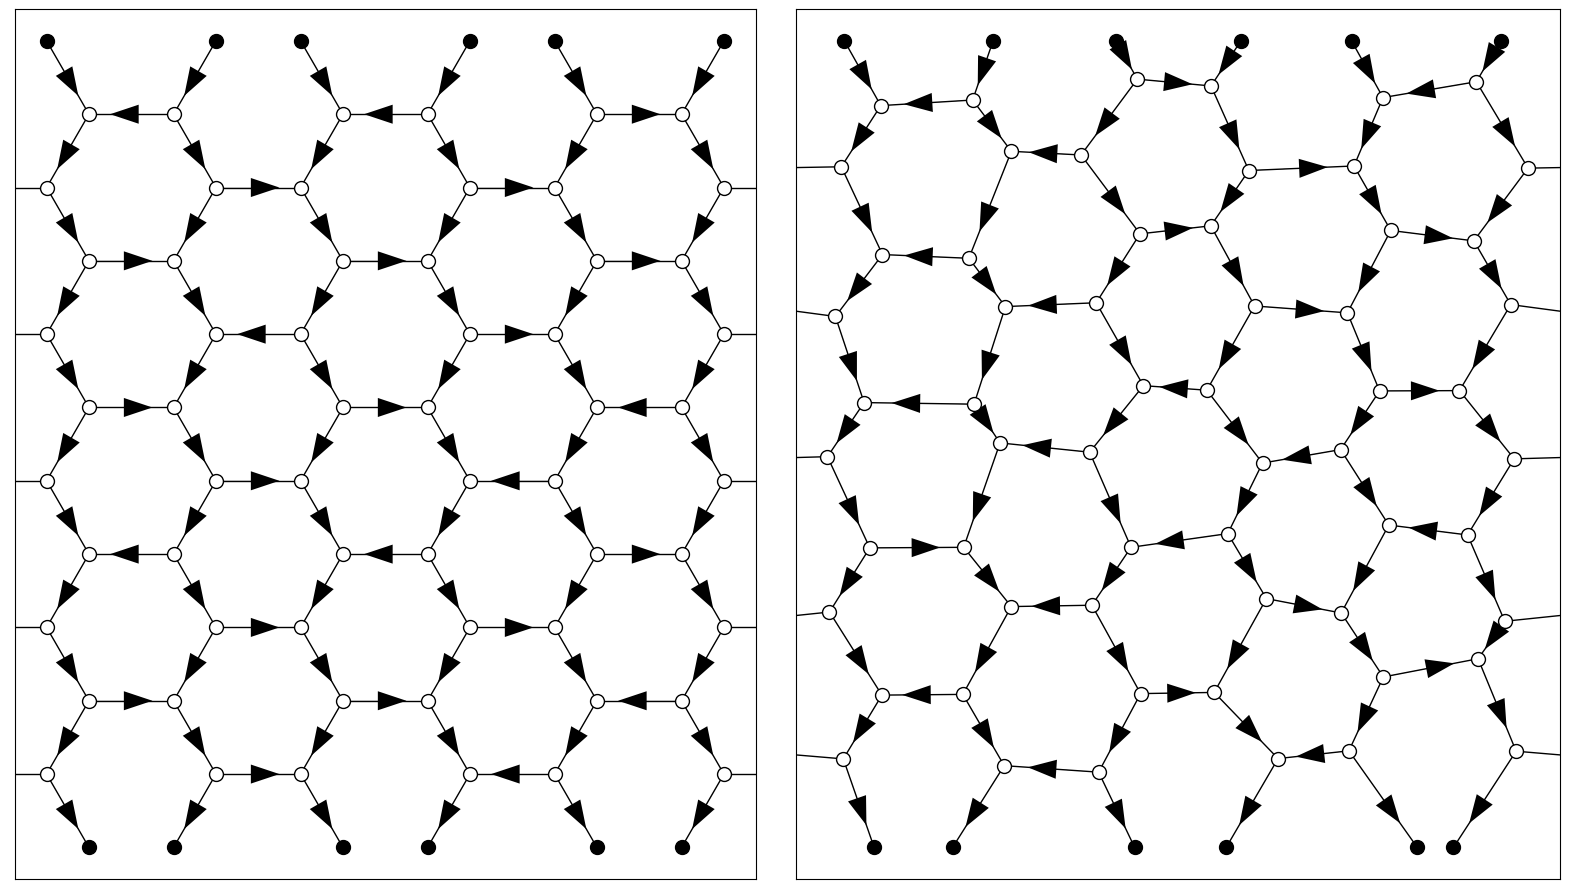

In [4]:
F = NetworkComparison()
F.plot()
F.save('network_comparison')

/Users/nathankarst/Dropbox/Research/Blood flow/2021_transit_time/skimming.py:10: RuntimeWarning: invalid value encountered in reciprocal
  f = 0*(q < x_0) + (1 + np.exp(-a - b*np.log(abs((q-x_0)/(1-q-x_0)))))**(-1)*(q >= x_0)*(q <= 1 - x_0) + 1*(q > 1-x_0)
/Users/nathankarst/Dropbox/Research/Blood flow/2021_transit_time/skimming.py:12: RuntimeWarning: invalid value encountered in true_divide
  f   = f/q
/Users/nathankarst/Dropbox/Research/Blood flow/2021_transit_time/skimming.py:13: RuntimeWarning: invalid value encountered in true_divide
  g   = (1 - f*q)/(1-q)


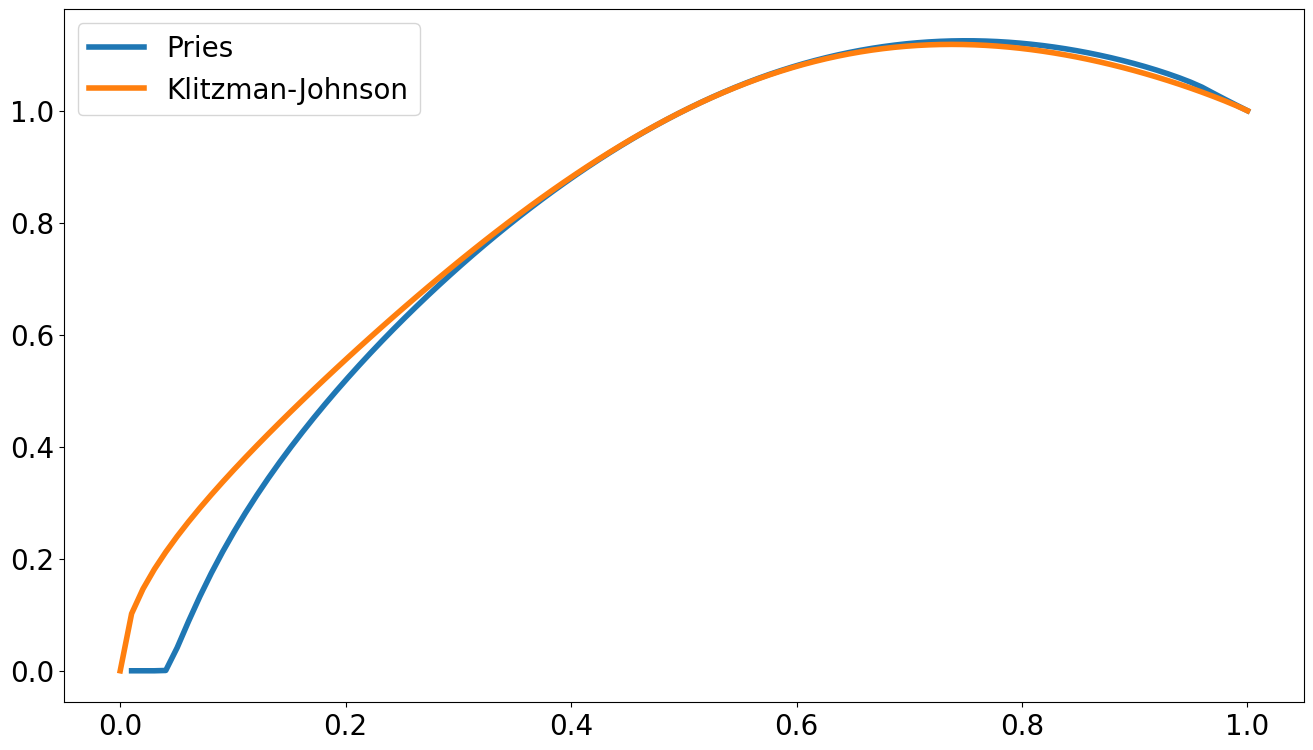

In [5]:
F = SkimmingComparison()
F.plot()
F.save('skimming_comparison')

/Users/nathankarst/Dropbox/Research/Blood flow/2021_transit_time/viscosity.py:32: RuntimeWarning: divide by zero encountered in power
  eta         = (1 + (eta_star - 1)*((1 - h)**c - 1)/ ((1 - 0.45)**c - 1) * (d/(d-1.1))**2)*(d/(d-1.1))**2;
/Users/nathankarst/Dropbox/Research/Blood flow/2021_transit_time/viscosity.py:11: RuntimeWarning: divide by zero encountered in power
  eta         = 1 + (eta_star - 1)*((1 - h)**c - 1)/((1 - 0.45)**c - 1)


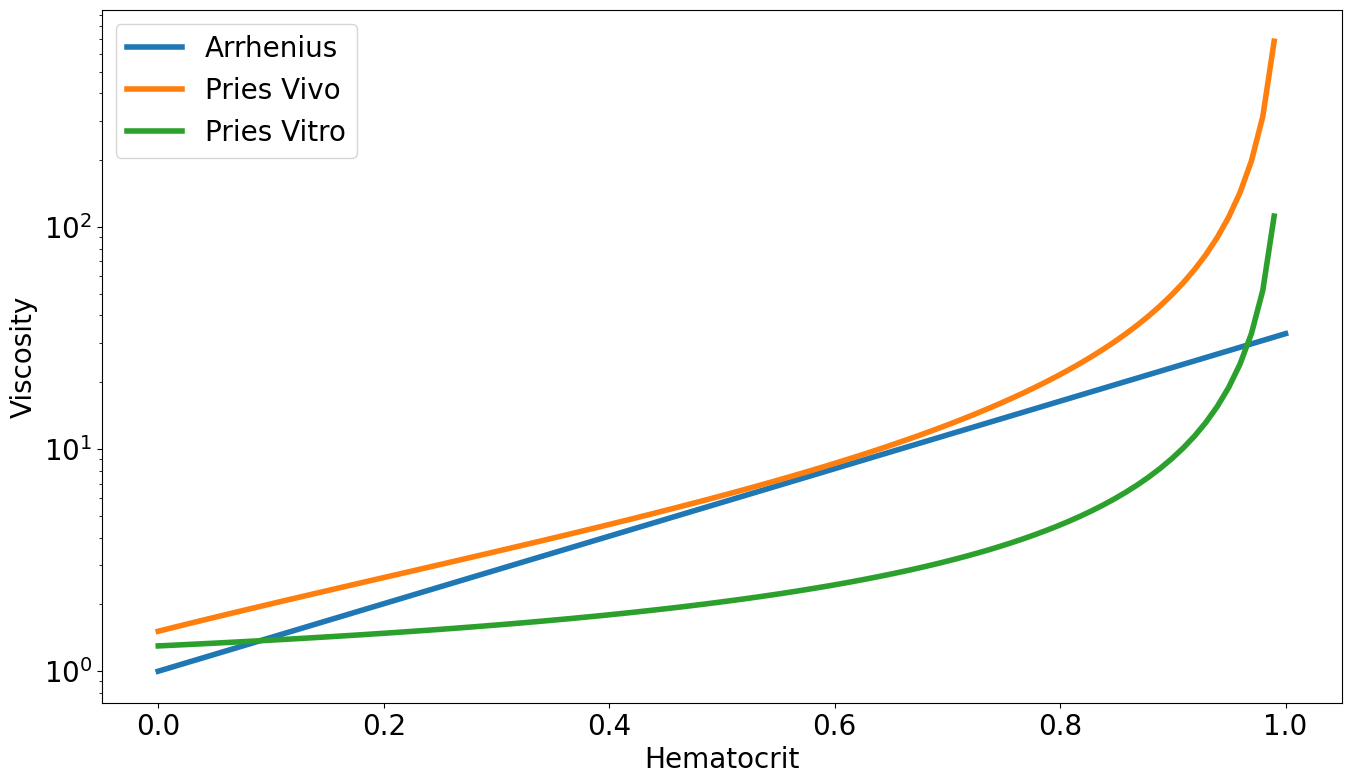

In [6]:
F = ViscosityComparison()
F.plot(delta=3.5,d=15)
F.save('viscosity_comparison')

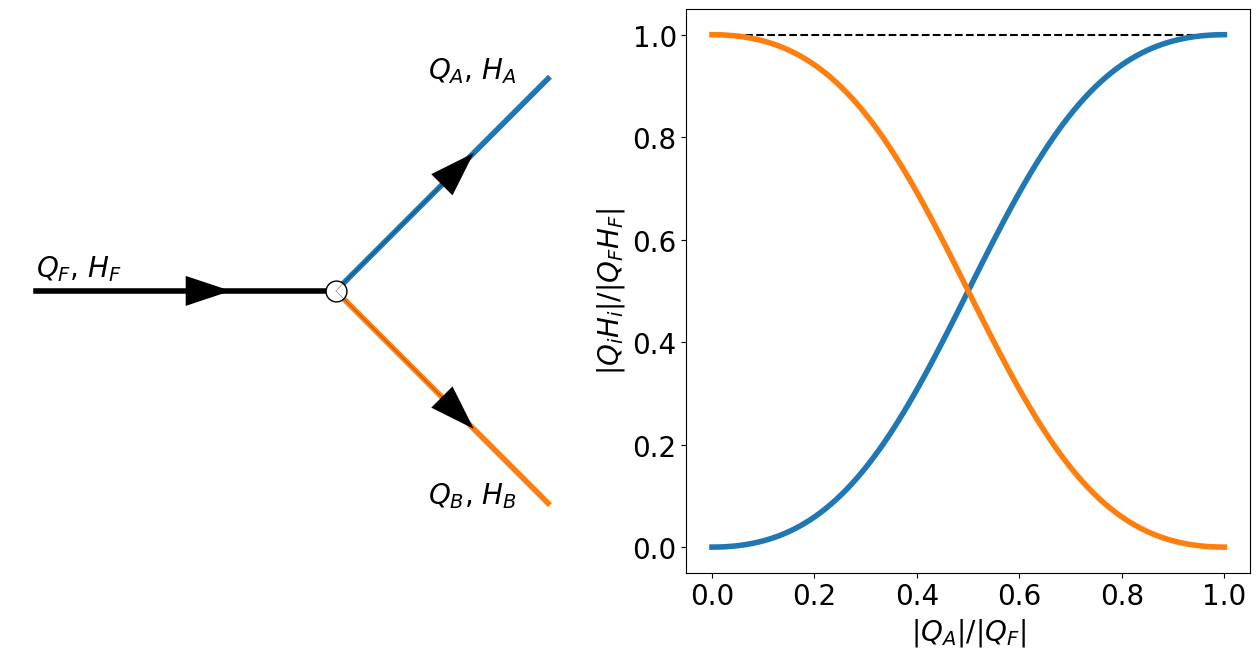

In [7]:
F = JunctionSkimming()
F.plot()
F.save('junction_skimming')

### Simple Network

In [8]:
class ProbabilityDistributionFigure(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self,normalizer=1,xlabel='Normalized Transit Time',scale='linear',alpha=1,colors='k',ms=10,mec='k'):
        taus = self.network.ttd.delays/normalizer

        if len(colors) == 1:
            colors = len(taus)*colors
        
        for i in range(len(taus)):
            plt.plot(taus[i],self.network.ttd.probs[i],'o',color=colors[i],ms=ms,alpha=alpha,mec=mec)
        
        plt.xlabel(xlabel)
        plt.ylabel('Probability []')
        
        plt.xscale(scale)
        plt.yscale(scale)
        
class CumulativeProbabilityDistributionFigure(ManuscriptFigure):
    def __init__(self,networks):
        if isinstance(networks,Network):
            self.networks = [networks]
        else:
            self.networks = networks
        super().__init__(self.networks[0])
        
    def plot(self,tau_max=3,tau_step=0.01,cull=True,
             confidence_interval=None,confidence_level=None,
             alpha=0.1,colors='k',fs=20):
        plt.figure(figsize=(16,9))
        
        taus = np.arange(0,tau_max,tau_step)
        
        F = [ManuscriptFigure(self.networks[i]) for i in range(len(self.networks))]
        for i,f in enumerate(F):
            plt.subplot(1,len(self.networks),i+1)
            if cull: 
                H = f.cull_equilibria()
            else: 
                H = f.network.equilibria
            n_eq = H.shape[1]        
        
            if type(colors) == str:
                colors = n_eq*[colors]
                        
            
            cumulative_distributions = np.zeros((len(taus),n_eq))                
            for j in range(n_eq):
                f.network.set_state(H[:,j])
                f.network.compute_ttd()          

                probs = np.zeros(taus.shape)
                normalized_delays = f.network.ttd.delays/f.network.ttd.expected_delay
                for k in range(len(taus)):
                    probs[k] = f.network.ttd.probs[normalized_delays <= taus[k]].sum()        
                plt.plot(taus,probs,color='k',alpha=alpha)

                cumulative_distributions[:,j] = probs            

            plt.gca().set_ylim((0,1))
            plt.gca().set_xlim((0,tau_max))
            plt.xlabel('Normalized Transit Time')
            f.set_font_size(fs)
            if i == 0: 
                plt.ylabel('Cumulative Probability')
                                        
            
            if confidence_interval == 'horizontal':
                if not confidence_level:
                    confidence_level = 0.8
                p = np.linspace(0.01,.99,11)
                median = np.zeros(p.shape)
                
                for j,pp in enumerate(p):
                    taus_at_p = np.zeros(n_eq)
                    for k in range(n_eq):
                        taus_at_p[k] = taus[(cumulative_distributions[:,k] >= pp).argmax()]
                    taus_at_p.sort()
                
                    left_idx = int(np.floor(len(taus_at_p)*(1-confidence_level)/2))+1
                    mid_idx = int(np.round(len(taus_at_p)/2))
                    right_idx = int(len(taus_at_p) - left_idx - 1)

                    left = taus_at_p[left_idx]
                    mid = taus_at_p[mid_idx]
                    right = taus_at_p[right_idx]                    
                    
                    print(f'percentile {pp:.2f} ({confidence_level:.2f} confidence): [{left:.2f},{right:.2f}]')
                    
                    plt.plot([left,right],[pp,pp],color=sns.color_palette()[i],alpha=.5,lw=8)
                    median[j] = mid
                    
#                 plt.plot(p,median,'lightblue',alpha=alpha,lw=2)
            
            elif confidence_interval == 'vertical':
                if not confidence_level:
                    confidence_level = 0.8                
                
                t = np.arange(0,tau_max,.25)
                
                median = np.zeros(t.shape)
                for j,tt in enumerate(t):
                    ps_at_tau = np.zeros(n_eq)
                    for k in range(n_eq):
                        ps_at_tau[k] = cumulative_distributions[(taus>=tt).argmax(),k]
                    ps_at_tau.sort()
                    
                    bottom_idx = int(np.floor(len(ps_at_tau)*(1-confidence_level)/2))+1
                    mid_idx = int(np.round(len(ps_at_tau)/2))
                    top_idx = int(len(ps_at_tau) - bottom_idx - 1)

                    bottom = ps_at_tau[bottom_idx]
                    mid = ps_at_tau[mid_idx]
                    top = ps_at_tau[top_idx]                               
                               
                    print(f'tau {tt:.2f} ({confidence_level:.2f} confidence): [{bottom:.2f},{top:.2f}]')
                    plt.plot([tt,tt],[bottom,top],color=sns.color_palette()[i],alpha=.6,lw=8)
                    median[j] = mid
                
class LadderNetworkAndCDF(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self,idx=0,lw=4,fs=20):
        self.network.set_state(self.network.equilibria[:,idx])
        self.network.compute_ttd()
        h = self.network.h
        q = self.network.pq[self.network.nNodes:]
        
        fig, ax = plt.subplots(1, 2, figsize=(16,9),gridspec_kw={'width_ratios':[2,1]})            
        plt.sca(ax[0])
        F1 = NetworkFigure(self.network)        
        F1.plot(directions=np.sign(q),annotate=False,node_colors=2*['k'] + 4*['w'] + 2*['k'])
        
        for i,edge in enumerate(self.network.e):
            i0 = min([edge[0],edge[1]])
            i1 = max([edge[0],edge[1]])        

            x0 = self.network.v[i0,0]
            y0 = self.network.v[i0,1]

            x1 = self.network.v[i1,0]
            y1 = self.network.v[i1,1]

            x_label = x0 + (x1-x0)/2
            y_label = y0 + (y1-y0)/2

            q_tot = q[0] + q[1]
            label = ''       
            label += '$Q_{' + str(i+1)+ '}= $' + str(np.round(q[i]/q_tot,2))
            label += '\n'
            label += '$H_{'  + str(i+1)+  '}= $' + str(np.round(h[i],2))    
            if i%3 == 2:
                plt.text(x_label-.3, y_label+.2,label,fontsize=fs)
            elif i%3 == 1:
                plt.text(x_label+.1, y_label,label,fontsize=fs)
            else: 
                plt.text(x_label-.9, y_label,label,fontsize=fs)
        F1.despine()
                

        plt.gca().set_aspect('equal')
        plt.xlim((-1,2))
        
        plt.sca(ax[1])
        F2 = ProbabilityDistributionFigure(N)
        
        vol_tot = np.sum(self.network.l*self.network.d**2/4*np.pi)
        normalizer = vol_tot/(q[0]+q[1])
        F2.plot(normalizer=normalizer,scale='log')
        F2.set_font_size(fs)
        
        print(self.network.ttd.delays/normalizer)
        
        ap = {'arrowstyle':'->'}
     
        vshift = [-.75,-1.5,-.25,-1,0]
        hshift = [0,-1.5,.5,-.5,-2]
        for i,path in enumerate(self.network.ttd.paths):
            label = '(' + ','.join([str(v+1) for v in path]) + ')'
            
            x = self.network.ttd.delays[i]/normalizer
            y = self.network.ttd.probs[i]
            plt.annotate(label,xytext=(x*2**hshift[i],y*2**vshift[i]),xy=(x,y),arrowprops=ap,fontsize=fs)
                      
class LadderEqs(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self,filename='ladder_2_eqs',lw=4,fs=10,alpha=0.75,ms=10):
        colors = list(mcolors.TABLEAU_COLORS.values())

        for i in range(self.network.equilibria.shape[1]):
            self.network.set_state(self.network.equilibria[:,i])
            q = self.network.pq[self.network.nNodes:]
            plt.plot(q[2],q[5],'o',c=colors[i],ms=ms,mec='k',alpha=alpha)
        plt.xlabel(r'Q$_{3,4}$')
        plt.ylabel(r'Q$_{5,6}$')
        plt.gca().set_aspect('equal')
        
        self.set_font_size(fs)
        
        self.save(filename)
                
class LadderPDFs(ManuscriptFigure):
    def __init__(self,network):
        super().__init__(network)
        
    def plot(self,filename='ladder_2_pdfs',lw=4,fs=10,alpha=0.75,ms=10):
        colors = list(mcolors.TABLEAU_COLORS.values())
        
        for i in range(self.network.equilibria.shape[1]):
            plt.subplot(3,3,i+1)
            self.network.set_state(self.network.equilibria[:,i])
            q = self.network.pq[self.network.nNodes:]
            
            normalizer = np.sum(np.pi*(self.network.l*self.network.d**2/4)) / (q[0] + q[1])
            
            self.network.compute_ttd()
            ProbabilityDistributionFigure(self.network).plot(colors=[colors[i]],scale='log',
                                      normalizer=normalizer,ms=ms,alpha=alpha)
            if i != 3: plt.gca().set_ylabel('')
            if i != 7: plt.gca().set_xlabel('')
            if i%3 != 0: plt.gca().set_yticks([])
            if i < 6: plt.gca().set_xticks([])
            plt.gca().set_xlim((.1,2000))
            plt.gca().set_ylim((1e-8,2)) 
            
            if i%3 == 0: 
                q34 = '<'
            elif i%3 == 1:
                q34 = '\\approx'
            else:
                q34 = '> '            
            
            if i//3 == 0: 
                q56 = '>'
            elif i//3 == 1:
                q56 = '\\approx'
            else:
                q56 = '< '
            
            plt.text(.99, .99, r'$Q_{3} ' + q34 + ' 0$' + "\n" + r'$Q_{6}' + q56 + ' 0$', ha='right', va='top', transform=plt.gca().transAxes)
        
        self.set_font_size(fs)
        
        self.save(filename)

In [9]:
N = load('ladder_2')

[0.41386447 2.33369226 0.46032892 2.78409917 4.70392696]


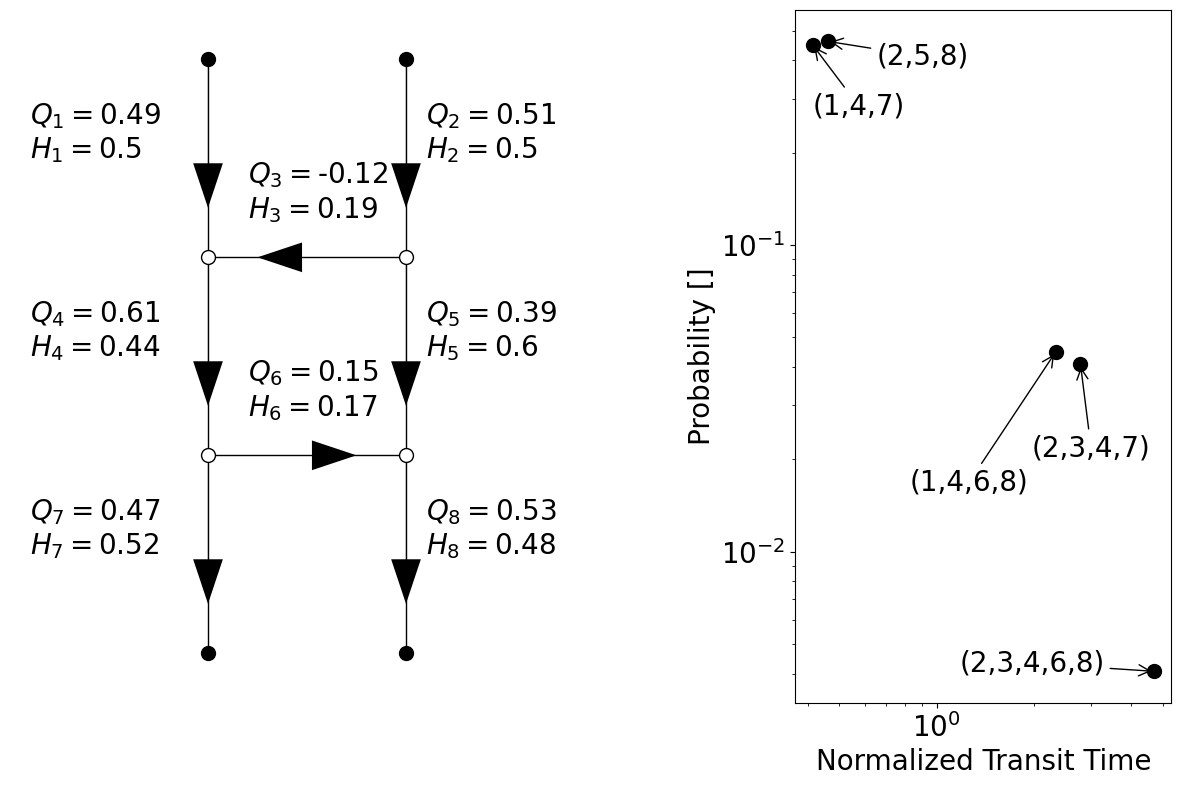

In [10]:
F = LadderNetworkAndCDF(N)
F.plot()
F.save('ladder_2_example')

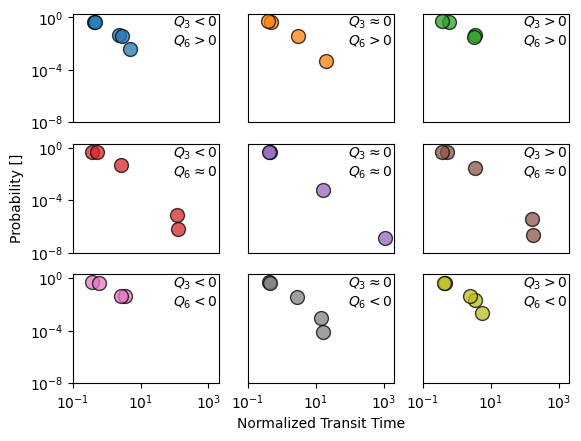

In [11]:
LadderPDFs(N).plot()

### Honeycomb Networks

In [12]:
P = load('nm_6_neq_1000_perturbed')
R = load('nm_6_neq_1000_regular')

In [13]:
class EquilibriumUnivariateFigure(ManuscriptFigure):
    def __init__(self,networks):
        if isinstance(networks,Network):
            self.networks = [networks]
        else:
            self.networks = networks
        super().__init__(self.networks[0])
        
    def plot(self,idx=0,var='h',kind='hist',
             norm=False,bins='auto',binwidth=None,binrange=None,
             fs=20,xlim_left=None,xlim_right=None,ylim_bottom=None,ylim_top=None,
             color='#1f77b4'):
        plt.figure(figsize=(16,9))
        
        F = [ManuscriptFigure(self.networks[i]) for i in range(len(self.networks))]
        for i,f in enumerate(F):
            plt.subplot(1,len(F),i+1)
            if var == 'h':
                x = f.network.equilibria[:,idx]
                xlabel = 'Hematocrit'

            elif var == 'q':
                x = np.abs(f.network.get_pq(f.network.equilibria[:,idx])[f.network.nNodes:])
                x /= np.sum(np.abs(x[f.network.exteriorFlows]))/2
                xlabel = 'Normalized Flow'
                
                
            elif var == 'mean' or var == 'std':
                color = 'orange'
                if var == 'mean':
                    xlabel = 'Mean Transit Time'
                elif var == 'std':
                    xlabel = 'Standard Deviation of Transit Time'                   
                
#                 H = f.network.equilibria
                H = f.cull_equilibria()
                n_eq = H.shape[1]

                x = np.zeros(n_eq)
                for j in range(n_eq):
                    f.network.set_state(H[:,j])
                    f.network.compute_ttd()
                    mu = np.sum(f.network.ttd.probs*f.network.ttd.delays)
                    if var == 'mean':
                        x[j] = mu
                    elif var == 'std':
                        x[j] = np.sqrt(np.sum((f.network.ttd.delays - mu)**2*f.network.ttd.probs))                    
                    

            stat = 'count'
            if norm:
                stat = 'proportion'
            
            if kind == 'hist':
                sns.histplot(x,stat=stat,bins=bins,binwidth=binwidth,binrange=binwidth,color=color)
                plt.xlabel(xlabel)
            elif kind == 'box':
                y = np.sort(x)
                print(y[int(len(y)*.25)],y[int(len(y)*.5)],y[int(len(y)*.75)])
                sns.boxplot(y=x,color=color)
                plt.ylabel(xlabel)
            
            if xlim_left: plt.gca().set_xlim(left=xlim_left)        
            if xlim_right: plt.gca().set_xlim(right=xlim_right)
            if ylim_bottom: plt.gca().set_ylim(bottom=ylim_bottom)
            if ylim_top: plt.gca().set_ylim(top=ylim_top)
            f.set_font_size(fs)
            
            if i > 0 :
                plt.ylabel('')        

class EquilibriumBivariateFigure(ManuscriptFigure):
    def __init__(self,networks):
        if isinstance(networks,Network):
            self.networks = [networks]
        else:
            self.networks = networks
        super().__init__(self.networks[0])
        
    def plot(self,kind='single',marginal='box',idx=0,
             fs=20,ms=5,
             xlim_left=None,xlim_right=None,ylim_bottom=None,ylim_top=None,
             color='#1f77b4',labels=[]):
        plt.figure(figsize=(16,9))
        
        F = [ManuscriptFigure(self.networks[i]) for i in range(len(self.networks))]
        X = []
        Y = []
        N = []
        L = []
        for i,f in enumerate(F):        
            if kind == 'single':
                x = np.abs(f.network.get_pq(f.network.equilibria[:,idx])[f.network.nNodes:])    
                x /= np.sum(np.abs(x[f.network.exteriorFlows]))/2    
                y = f.network.equilibria[:,idx]
                
                q = np.linspace(0,1,100)
                h = (0.45*(1/6))/q
                L = q*2.7
                   
                xlabel = 'Normalized Flow'                
                ylabel = 'Hematocrit'
            elif kind == 'multi':
                H = f.cull_equilibria()
                n_eq = H.shape[1]

                x = np.zeros(n_eq)
                y = np.zeros(n_eq)
                for j in range(n_eq):
                    f.network.set_state(H[:,j])
                    f.network.compute_ttd()
                    mu = np.sum(f.network.ttd.probs*f.network.ttd.delays)
                    x[j] = mu
                    y[j] = np.sqrt(np.sum((f.network.ttd.delays - mu)**2*f.network.ttd.probs))  
                    
                xlabel = 'Mean Transit Time'
                ylabel = 'Standard Deviation of Transit Time'                    
            
                L.append(np.polyfit(x,y,1))
                
                
                
                
            X += list(x)
            Y += list(y)
            if len(labels) >= (i+1):
                N += [labels[i]]*len(x)
            else:
                N += [str(i)]*len(x)
            

            
        g = sns.JointGrid(x=X, y=Y, hue=N)
        g.plot_joint(sns.scatterplot,alpha=.6,s=50)
        
        if marginal == 'kde':
            g.plot_marginals(sns.kdeplot,bw_adjust=.3)
        if marginal == 'box':
            sns.boxplot(x=g.hue, y=g.y, ax=g.ax_marg_y)
            sns.boxplot(y=g.hue, x=g.x, ax=g.ax_marg_x)

        if kind == 'single':
            g.ax_joint.plot(q,h,'k',alpha=0.25,zorder=-1)
            g.ax_joint.plot(q,L,'k',alpha=0.25,zorder=-1)
        if kind == 'multi':
            slopes = 1/np.arange(1,11,1)
            for slope in slopes:
                g.ax_joint.plot([0,xlim_right],[0,slope*xlim_right],'k',alpha=.25,zorder=-1)
            tau = np.linspace(xlim_left,xlim_right,3)
            for i in range(len(F)):
#                 g.ax_joint.plot(tau,L[i][0]*tau + L[i][1],'k',alpha=.25,zorder=-1)
                print(f'Slope = {L[i][0]}')

        g.ax_joint.set_xlim(xlim_left,xlim_right)
        g.ax_joint.set_ylim(ylim_bottom,ylim_top)

        g.set_axis_labels(xlabel=xlabel, ylabel=ylabel)
        
        self.set_font_size(fs)

In [14]:
print(ManuscriptFigure(R).cull_equilibria().shape)
print(ManuscriptFigure(P).cull_equilibria().shape)

/var/folders/f6/q5_h8mfs1szcx3l6mr5254m00000gn/T/ipykernel_99199/550230734.py:98: RuntimeWarning: divide by zero encountered in true_divide
  h = (0.45*(1/6))/q


<Figure size 1600x900 with 0 Axes>

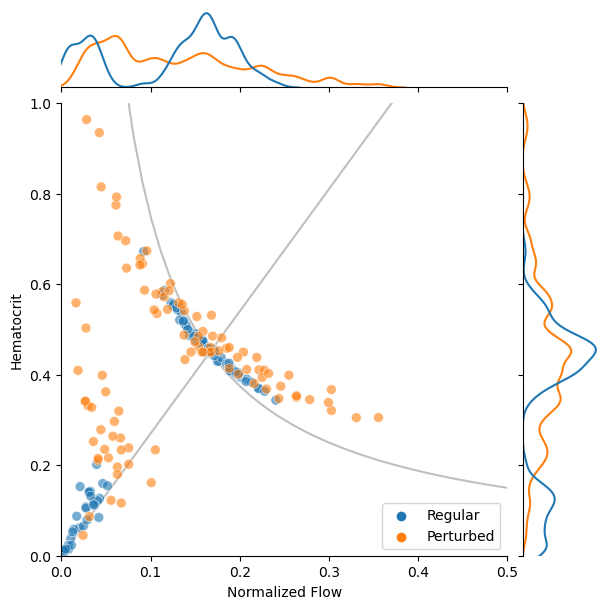

In [16]:
F = EquilibriumBivariateFigure([R,P])
F.plot(kind='single',marginal='kde',xlim_left=0,xlim_right=0.5,ylim_bottom=0,ylim_top=1,labels=['Regular','Perturbed'])
F.save('joint_q_h')

Slope = 1.144191533937221
Slope = 1.9207169414008296


<Figure size 1600x900 with 0 Axes>

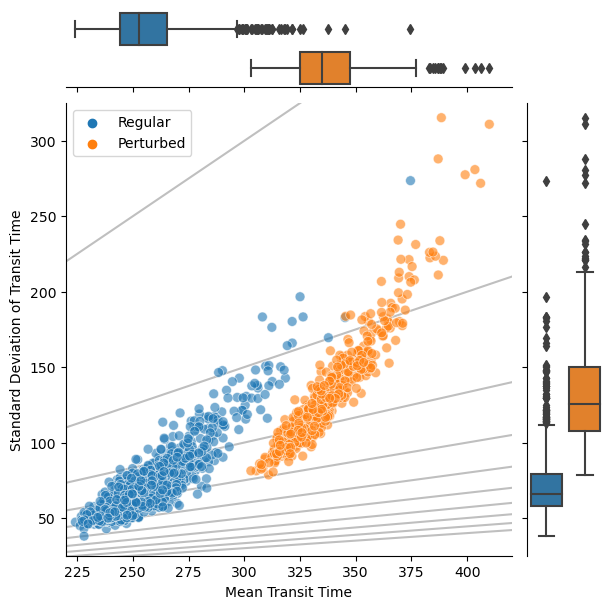

In [17]:
F = EquilibriumBivariateFigure([R,P])
F.plot(kind='multi',xlim_left=220,xlim_right=420,ylim_bottom=25,ylim_top=325,labels=['Regular','Perturbed'])
F.save('joint_mctt_ctth')

percentile 0.01 (0.80 confidence): [0.58,0.80]
percentile 0.11 (0.80 confidence): [0.58,0.80]
percentile 0.21 (0.80 confidence): [0.69,0.87]
percentile 0.30 (0.80 confidence): [0.72,0.92]
percentile 0.40 (0.80 confidence): [0.79,0.94]
percentile 0.50 (0.80 confidence): [0.88,1.02]
percentile 0.60 (0.80 confidence): [0.94,1.08]
percentile 0.70 (0.80 confidence): [1.00,1.18]
percentile 0.79 (0.80 confidence): [1.06,1.29]
percentile 0.89 (0.80 confidence): [1.22,1.52]
percentile 0.99 (0.80 confidence): [1.63,1.98]
percentile 0.01 (0.80 confidence): [0.54,0.66]
percentile 0.11 (0.80 confidence): [0.56,0.67]
percentile 0.21 (0.80 confidence): [0.59,0.71]
percentile 0.30 (0.80 confidence): [0.63,0.77]
percentile 0.40 (0.80 confidence): [0.74,0.88]
percentile 0.50 (0.80 confidence): [0.83,0.97]
percentile 0.60 (0.80 confidence): [0.92,1.07]
percentile 0.70 (0.80 confidence): [1.03,1.21]
percentile 0.79 (0.80 confidence): [1.20,1.39]
percentile 0.89 (0.80 confidence): [1.38,1.74]
percentile 0.

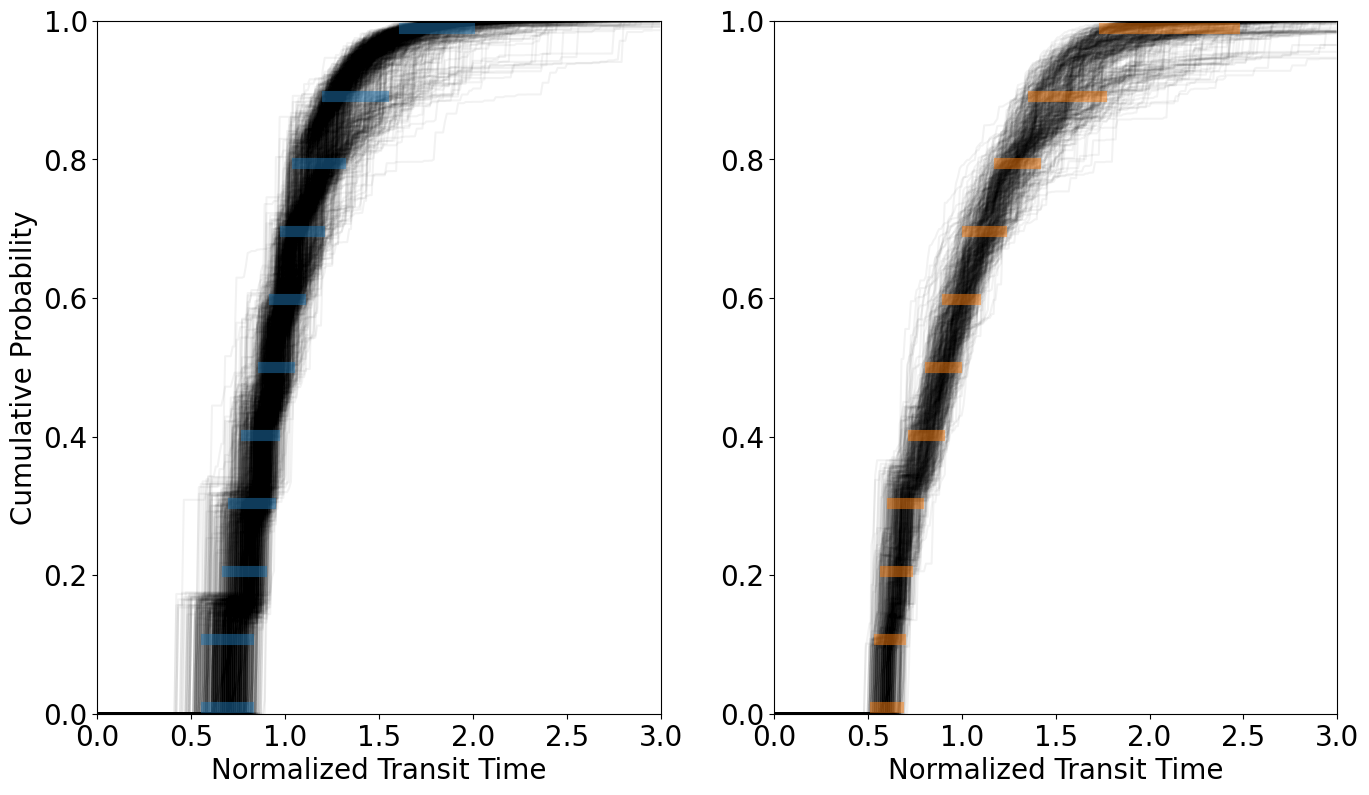

In [18]:
F = CumulativeProbabilityDistributionFigure([R,P])
F.plot(alpha=.05,confidence_interval='horizontal')
F.save('cdf_comparison_horizontal_confidence')

tau 0.00 (0.80 confidence): [0.00,0.00]
tau 0.25 (0.80 confidence): [0.00,0.00]
tau 0.50 (0.80 confidence): [0.00,0.00]
tau 0.75 (0.80 confidence): [0.00,0.32]
tau 1.00 (0.80 confidence): [0.47,0.70]
tau 1.25 (0.80 confidence): [0.77,0.91]
tau 1.50 (0.80 confidence): [0.89,0.98]
tau 1.75 (0.80 confidence): [0.97,1.00]
tau 2.00 (0.80 confidence): [0.99,1.00]
tau 2.25 (0.80 confidence): [1.00,1.00]
tau 2.50 (0.80 confidence): [1.00,1.01]
tau 2.75 (0.80 confidence): [1.00,1.01]
tau 0.00 (0.80 confidence): [0.00,0.00]
tau 0.25 (0.80 confidence): [0.00,0.00]
tau 0.50 (0.80 confidence): [0.00,0.00]
tau 0.75 (0.80 confidence): [0.27,0.42]
tau 1.00 (0.80 confidence): [0.54,0.67]
tau 1.25 (0.80 confidence): [0.72,0.83]
tau 1.50 (0.80 confidence): [0.84,0.94]
tau 1.75 (0.80 confidence): [0.90,0.99]
tau 2.00 (0.80 confidence): [0.93,1.00]
tau 2.25 (0.80 confidence): [0.98,1.00]
tau 2.50 (0.80 confidence): [0.99,1.00]
tau 2.75 (0.80 confidence): [1.00,1.00]


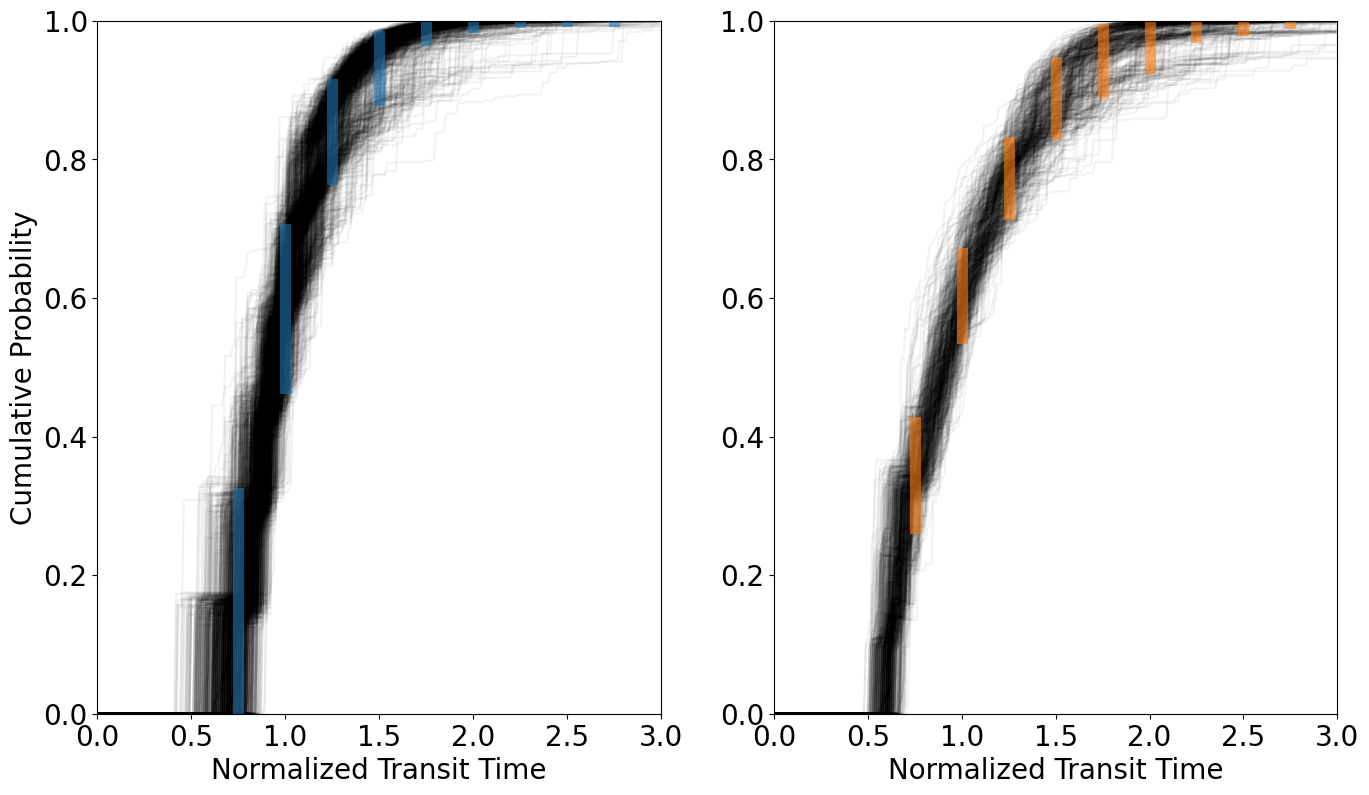

In [19]:
F = CumulativeProbabilityDistributionFigure([R,P])
F.plot(alpha=.05,confidence_interval='vertical')
F.save('cdf_comparison_vertical_confidence')